In [1]:
#load packages
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import soundfile as sf

In [6]:
#load the saved model 
json_file = open('NN_OwnVoice_36-19-2_inputs_uniBF_1-chanMF.json', 'r')
loaded_model_json = json_file.read()
loaded_model = keras.models.model_from_json(loaded_model_json)

#load weights
loaded_model.load_weights("NN_OwnVoice_36-19-2_inputs_uniBF_1-chanMF_weights.h5")

ValueError: Unknown layer:name

In [7]:
#load test data
path = 'x:/Steering/Recordings/Processed/'
testX = np.load(path + 'TestX_NN_OwnVoice_uniBF_1-chanMF.npy')
testY = np.load(path + 'TestY_NN_OwnVoice_uniBF_1-chanMF.npy')
one_hot_test = np.load(path + 'OneHot_testY_uniBF_1-chanMF.npy')

In [ ]:
testY

In [5]:
loaded_model.compile(loss='mean_squared_error',
    optimizer='Adam',
           metrics=['categorical_accuracy'])

In [6]:
loaded_model.evaluate(testX,one_hot_test,verbose=1)

195871/195871 [==============================] - 3s 14us/step


[0.1737075545082297, 0.7770981921732443]

In [7]:
#process weights
weights_first_layer = loaded_model.layers[0].get_weights()[0]
biases_first_layer = loaded_model.layers[0].get_weights()[1]

weights_second_layer = loaded_model.layers[1].get_weights()[0]
biases_second_layer = loaded_model.layers[1].get_weights()[1]

In [8]:
weights_first_layer = np.vstack([biases_first_layer, weights_first_layer])
weights_second_layer = np.vstack([biases_second_layer, weights_second_layer])

#tmp1 = abs(np.vstack([weights_first_layer, biases_first_layer])).max()
#tmp2 = abs(np.vstack([weights_second_layer, biases_second_layer])).max()

In [9]:
weights_first_layer_norm = weights_first_layer / abs(weights_first_layer).max()
#biases_first_layer_norm = biases_first_layer / abs(biases_first_layer).max()

weights_second_layer_norm = weights_second_layer / abs(weights_second_layer).max()
#biases_second_layer_norm = biases_second_layer / tmp2 #abs(biases_second_layer).max()

In [10]:
abs(weights_first_layer).max(), abs(weights_second_layer).max()

(2.0591824, 4.121691)

In [11]:
weights_first_layer.shape, weights_second_layer.shape

((37, 19), (20, 2))

In [12]:
np.savetxt('weights_first_layer_norm_NN_36-19-2_ownVoice_1-chan_MF.txt',
           weights_first_layer_norm,delimiter= ',')
np.savetxt('weights_second_layer_norm_NN_36-19-2_ownVoice_1-chan_MF.txt',
           weights_second_layer_norm,delimiter= ',')


In [13]:
# calculate confusion matrix
testX.shape,one_hot_test.shape

((195871, 36), (195871, 2))

In [14]:
loaded_model.predict_classes(testX) - testY

array([-1,  0, -1, ...,  0,  0,  0], dtype=int64)

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [16]:
cfm = confusion_matrix(testY,loaded_model.predict_classes(testX)) 

In [17]:
cfm

array([[115614,   6906],
       [ 36754,  36597]], dtype=int64)

In [18]:
cfm_norm = np.zeros((2,2))

In [19]:
cfm_norm

array([[0., 0.],
       [0., 0.]])

In [20]:
for idx in range(2):
    cfm_norm[idx,:] = cfm[idx,:] / sum(cfm[idx,:]) #len(testY[testY == idx])  
    

In [21]:
cfm_norm = np.around(cfm_norm,decimals=3)

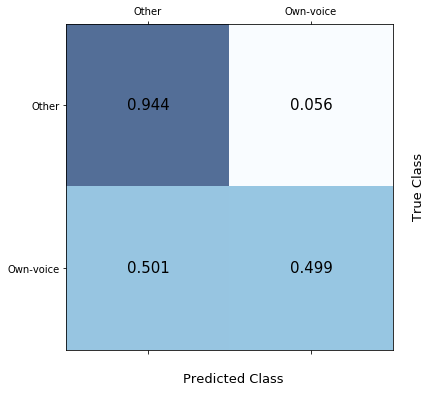

In [22]:
#nicer confusion matrix
fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cfm_norm,cmap=plt.cm.Blues,alpha=0.7)

for i in range(cfm_norm.shape[0]):
    for j in range(cfm_norm.shape[1]):
        ax.text(x=j,y=i, s=cfm_norm[i,j],va='center', ha= 'center',fontsize=15)
  
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Other','Own-voice'])
ax.set_yticklabels(['Other','Own-voice'])
ax.yaxis.set_label_coords(1.1,0.5)
ax.xaxis.set_label_coords(0.51,-0.07)
ax.set_xlabel('Predicted Class',fontsize=13)
ax.set_ylabel('True Class',fontsize=13)
fig.savefig('Conf_Matrix_OwnVoice_uniBF_1-chan_MF.png',dpi=100)


In [25]:
FP = cfm_norm.sum(axis=0) - np.diag(cfm_norm)  
FN = cfm_norm.sum(axis=1) - np.diag(cfm_norm)
TP = np.diag(cfm_norm)
TN = cfm_norm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negaive rate
FNR = FN/(TP + FN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [26]:
ACC.mean(),TPR.mean(), FPR.mean(), FNR.mean()

(0.7215, 0.7215, 0.27849999999999997, 0.2785)